## <center>Ultimate Inc. Challenge

### 1.0 Import the Library and Load the Data 

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# Read login data from the 'logins.json' file
file = 'logins.json'
f = open(file)
logins = json.loads(f.read())
f.close()

### 2. 0 Exploratory Data Analysis (EDA)

In [3]:
# Inspect keys
logins.keys()

dict_keys(['login_time'])

In [4]:
# Print the length of the 'login_time' list
print(len(logins['login_time']))

93142


In [5]:
# Create dataframe
df_logins = pd.DataFrame(pd.to_datetime(logins['login_time']),columns=['login_time'])
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
# Check for 'Na' values
df_logins[df_logins['login_time'].isna()].shape

(0, 1)

In [7]:
# Add count column for resample
df_logins['count'] = 1

In [8]:
# Set login time as index for resampling
df_logins.index = df_logins['login_time']

In [9]:
# Drop redundant column
df_logins.drop('login_time',axis=1,inplace=True)
df_logins.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


In [10]:
# Resample login data to 15-minute intervals and calculate the sum
df_count = df_logins.resample('15min').sum()

<Axes: xlabel='login_time'>

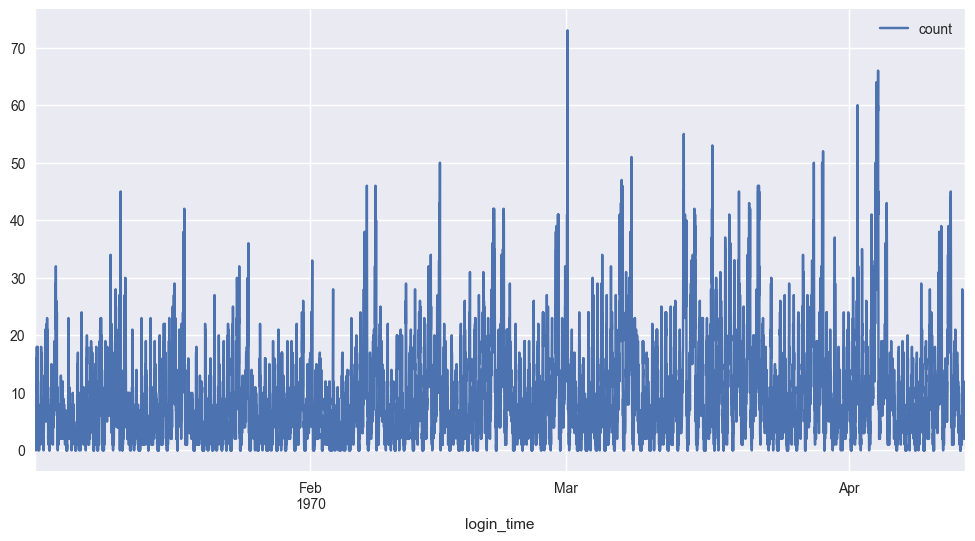

In [11]:
# Create a line plot for the resampled data
df_count.plot(kind='line', figsize=(12, 6))

#### <center> When we plot the 15-minute intervals over the 4-month period, we observe a sinusoidal pattern with an increasing average value.

In [12]:
# Calculate summary statistics for the resampled data
df_count.describe().T

,count,mean,std,min,25%,50%,75%,max
count,9788.0,9.515938,8.328818,0.0,3.0,7.0,13.0,73.0


On average, there are 7 logins per 15 minutes. However, the presence of spikes in our dataset is causing the mean to be higher. Now, let’s explore the daily distribution of logins.

In [13]:
# Add columns for month day and weekday to the resampled data
df_count = df_count.assign(month_day=df_count.index.day)
df_count = df_count.assign(weekday=df_count.index.weekday)
df_count.head()

,count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3


In [14]:
# Identify spikes in login counts
spike = np.quantile(df_count, 0.99)
df_spike = df_count[df_count['count'] >= spike]

# Extract month days and weekdays from the spike dates
month_days = []
weekdays = []
for date in df_spike.index:
    month_days.append(date.day)
    weekdays.append(date.weekday())

# Create DataFrames for spike days and weekdays
df_spike_days = pd.DataFrame(month_days, columns=['day'], index=range(len(month_days)))
df_spike_weekdays = pd.DataFrame(weekdays, columns=['weekday'], index=range(len(weekdays)))

In [15]:
# Count the occurrences of each day in the spike data
df_spike_days.day.value_counts()[0:10]

day
21    25
4     24
22    18
15    18
28    17
7     15
8     15
14    14
29    14
3     13
Name: count, dtype: int64

In [16]:
# Count the occurrences of weekdays in the spike data
df_spike_weekdays.weekday.value_counts()

weekday
5    104
6    103
4     48
3     15
2      7
1      7
0      2
Name: count, dtype: int64

The surge in user logins predominantly happens during weekends, which aligns with the increased usage of ride-sharing apps for social events like parties and outings.

Now, let’s explore the daily frequency data.

<Axes: xlabel='login_time'>

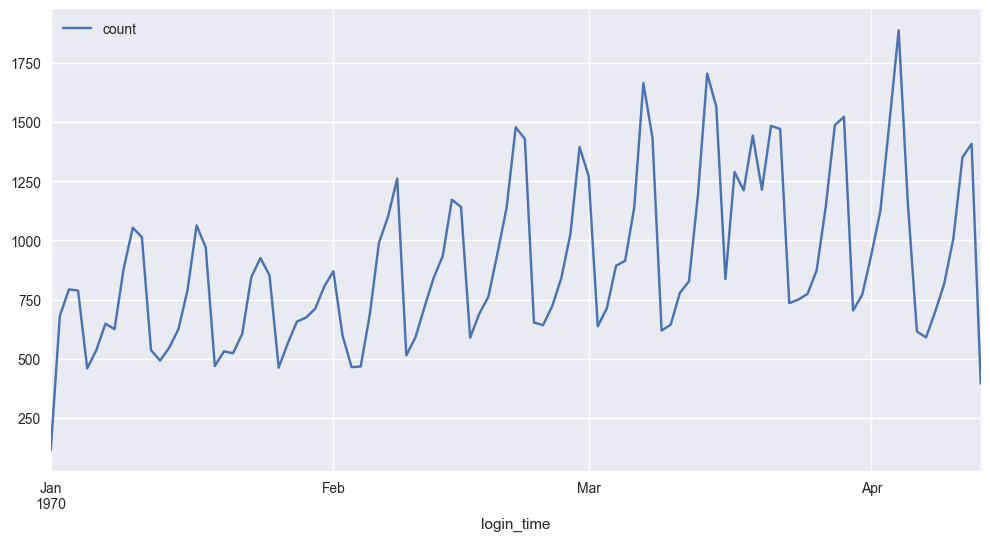

In [17]:
# Resample to daily frequency
df_day = df_logins.resample('1D').sum()
df_day.plot(kind='line',figsize=(12,6))

Upon resampling to daily frequency, we observe an upward trend in the average number of logins. Initially, during January, there appears to be minimal variation in the daily average. However, starting from February, we notice a clear increasing trend. Linear model plots can help validate or refute this observation.

Text(0.5, 28.999999999999986, 'Day')

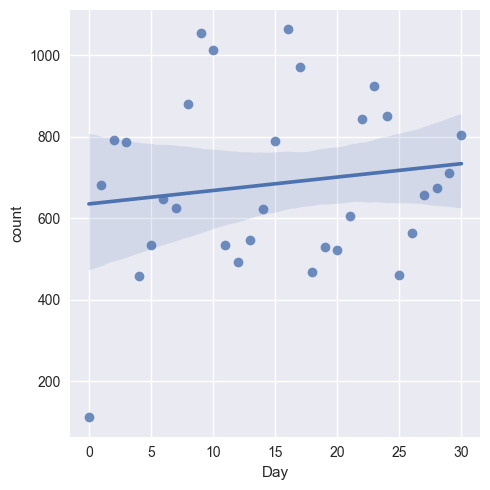

In [18]:
# Plot January trend
plot_df = df_day[df_day.index.month==1]
plot_df = plot_df.assign(x = range(plot_df.shape[0]))
sns.lmplot(data=plot_df,x='x',y='count')
plt.xlabel('Day')

During February, March, and April, we observe a noticeable upward trend.

### 3.0 Pre-processing and Modeling

In [19]:
# Import data from json file
file = 'ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df = pd.DataFrame(data)

In [20]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [21]:
# Inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
# Break down trip counts by percentage
df_tripcounts = df['trips_in_first_30_days'].value_counts(normalize=True)*100
df_tripcounts.head(7)

trips_in_first_30_days
0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
Name: proportion, dtype: float64

 ### 3.1 Cleaning Dataset 

In [23]:
# Remove rows where the 'phone' column is missing
df = df.drop(df[df.phone.isna() == True].index, axis=0)

In [24]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [25]:
# Calculate summary statistics for the 'avg_rating_by_driver' column
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [26]:
# Fill missing values by averaging the mean and median
fill_val = (4.777861+5) / 2
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=fill_val)

In [27]:
# Fill missing values with median value
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=4.9)

In [28]:
# Inspect data after cleaning, everything looks to be in order
# We have a clean dataset with minimal reduction in its size
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


Active users are defined as those who have engaged in any activity within the preceding 30 days. Although the take-home challenge writeup doesn’t specify the current date, we can assume that the latest date in the dataset represents the current date for our calculations.

### 3.2 Feature Engineering 

In [29]:
# Convert to timestamp
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [30]:
# Set current date 
current_date = df['last_trip_date'].max()

In [31]:
# Find if user qualifies as active
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


By the end of the six-month period, only 37.6% of users remain active. Our next step is to construct a predictive model that can identify the factors associated with user activity. Given the dataset’s low dimensionality, we won’t need to employ techniques like PCA for dimensionality reduction. Instead, we’ll use the Random Forest Classifier, which is effective for prediction and provides insights into feature importance.

In [32]:
# Create dummy variables for categorical features
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,False,True,False,False,True,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,True,False,False,True,False,True,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,True,False,False,False,True,True,False
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,False,True,False,False,True,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,False,False,True,True,False,True,False


In [33]:
# Set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

### 3.3 Exploratory Data Analysis (EDA) 

<Axes: xlabel='active', ylabel='avg_dist'>

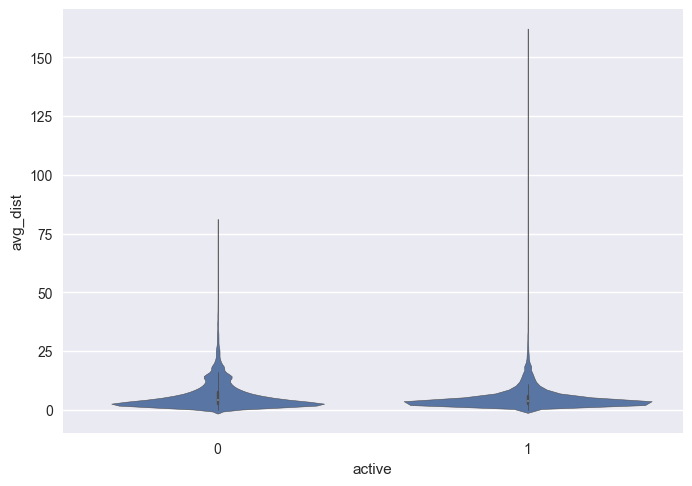

In [34]:
# Visualize difference in average distance by activity of user
sns.violinplot(data=df,x='active',y='avg_dist')

In [35]:
# Create a pivot table to calculate the mean and standard deviation of 'avg_dist' based on the 'active' column
pd.pivot_table(df, index='active', aggfunc={'avg_dist': ['mean', 'std']})

avg_dist          
            mean       std
active                    
0       6.190725  6.184010
1       5.113930  4.617779

Let’s break down the information and proceed with plotting the average rating by drivers for active versus inactive users.

1. <b> Difference in Average Distance:</b>
    - It’s noteworthy that there exists a difference in the average distance per trip taken during the first 30 days between active users and inactive users. This disparity could play a crucial role in our predictive modeling efforts.

2. <b> Average Rating by Drivers:</b>
    - Another informative factor is the average rating given by drivers. Let’s create a plot to compare this metric between active and inactive users.

Now, let’s proceed with the plot! 

(3.5, 5.2)

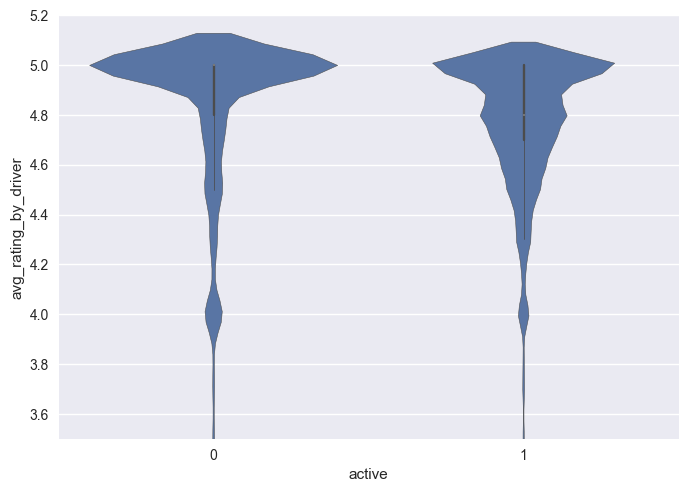

In [36]:
# Create a violin plot comparing the average rating by drivers for active vs. inactive users
sns.violinplot(data=df, x='active', y='avg_rating_by_driver')
plt.ylim([3.5, 5.2])

In [37]:
# Create a pivot table using the DataFrame 'df', indexing by the 'active' column, 
# and aggregating the 'avg_rating_by_driver' column with median and standard deviation
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503901
1                       4.8  0.328753

Active users tend to receive lower ratings than inactive users. This phenomenon may be attributed to the fact that active users typically have more total trips, increasing the likelihood of encountering situations that lead drivers to rate them below 5. Consequently, this feature appears crucial for predictive modeling.

In [38]:
# Create a pivot table using the DataFrame 'df', indexing by the 'active' column,
# and aggregating the 'trips_in_first_30_days' column with mean and standard deviation
pd.pivot_table(df,index='active',aggfunc={'trips_in_first_30_days':['mean','std']})

trips_in_first_30_days          
                         mean       std
active                                 
0                    1.657033  2.655767
1                    3.304804  4.985057

Active users tend to take more trips within their first 30 days. However, verifying this trend through hypothesis testing is unnecessary; our primary goal is to identify patterns relevant for our predictive model.

### 3.4. Building Predictive Model

In [39]:
# Calculate the percentage distribution of active status in the DataFrame 'df'
df.active.value_counts(normalize=True)*100

active
0    62.35989
1    37.64011
Name: proportion, dtype: float64

In [40]:
# Apply quantile transformation to scale features in 'df_features' using QuantileTransformer
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [41]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [42]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [43]:
# Calculate the accuracy score of the Random Forest model on the test set (X_test, y_test)
rf.score(X_test, y_test)

0.7487148472936196

In [44]:
# Perform 5-fold cross-validation on the Random Forest model using the test set (X_test, y_test)
print(cross_val_score(rf, X_test, np.ravel(y_test), cv=5))

# Calculate and print the mean cross-validated score of the Random Forest model
print('Mean Cross Validated Score:', np.mean(cross_val_score(rf, X_test, np.ravel(y_test), cv=5)))

[0.75214106 0.74647177 0.75       0.74747984 0.74647177]
Mean Cross Validated Score: 0.7499241285447307


In [45]:
# Create a DataFrame to store feature importances calculated by the Random Forest model
df_importance = pd.DataFrame(zip(list(df_features.columns), rf.feature_importances_), index=range(df_features.columns.shape[0]), columns=['feature', 'importance'])

# Sort the DataFrame by importance values in descending order
df_importance.sort_values(by='importance', ascending=False)

,feature,importance
5,avg_dist,0.300647
4,weekday_pct,0.132630
6,avg_rating_by_driver,0.113529
0,trips_in_first_30_days,0.080950
1,avg_rating_of_driver,0.080693
3,surge_pct,0.078458
2,avg_surge,0.066973
8,city_King's Landing,0.047489
11,phone_iPhone,0.019635
10,phone_Android,0.019543


In comparison to average distance driven, weekday percentage, and the rating provided by the driver, factors such as city, phone type, and ultimate black user status exhibit relatively lower importance for the model.

In [46]:
# Calculate precision, recall, F1 score, and support for the test predictions 'y_pred' compared to true labels 'y_test'
precision_recall_fscore_support(y_test, y_pred)

(array([0.80016194, 0.66390817]),
 array([0.79693548, 0.66836872]),
 array([0.79854545, 0.66613098]),
 array([6200, 3721]))

In [47]:
# Calculate precision, recall, F1 score, and support for the test predictions 'y_pred' compared to true labels 'y_test', 
# using the weighted averaging strategy for multiclass classification
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.7490581941704629, 0.7487148472936196, 0.7488816833966456, None)

In [48]:
# Generate a confusion matrix to evaluate the performance of predictions 'y_pred' against true labels 'y_test'
confusion_matrix(y_test, y_pred)

array([[4941, 1259],
       [1234, 2487]])

Although achieving 75% accuracy is promising, let's further enhance our model performance by exploring a logistic regression model with hyper-parameter tuning. Given our insight into feature importances from the random forest model, this approach holds potential for improvement.

In [49]:
# Initialize model
logit = LogisticRegression(solver='lbfgs')

In [50]:
# Set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}

In [51]:
# Instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [52]:
# Retrieve the value of the regularization parameter 'C' from the best estimator selected by the grid search
grid.best_estimator_.C

4.499999999999999

In [53]:
# Initialize a logistic regression model with the optimal regularization parameter 'C' obtained from grid search
logit_coef = LogisticRegression(C=grid.best_estimator_.C)

# Fit the logistic regression model to the training data
logit_coef.fit(X_train, y_train)

# Create a DataFrame to store the coefficients of features derived from the logistic regression model
df_coef = pd.DataFrame(zip(list(df_features.columns), logit_coef.coef_[0]), index=range(df_features.columns.shape[0]), columns=['feature', 'coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.071560
1,avg_rating_of_driver,-0.460262
2,avg_surge,2.999610
3,surge_pct,-1.951825
4,weekday_pct,-0.236517
5,avg_dist,0.148752
6,avg_rating_by_driver,-1.323771
7,city_Astapor,-0.759449
8,city_King's Landing,1.133005
9,city_Winterfell,-0.242344


In [54]:
# Calculate the mean cross-validated score of the grid search model using 5-fold cross-validation on the test set (X_test, y_test)
print(np.mean(cross_val_score(grid, X_test, np.ravel(y_test), cv=5)))

0.7430702039489722


Utilizing Logistic Regression for our classifier did not yield any advantage; both models perform nearly identically.

In summary, this dataset has provided valuable insights.

Firstly, we constructed a predictive model achieving 75% accuracy, valuable for future predictions.

Secondly, the model's insights are pivotal for the company's success. Random Forest highlighted crucial features, while Logistic Regression illustrated feature effects via coefficients. Considering the top three features, their impacts on rider "activity" after six months are as follows:
    
   1. <b> Average distance:</b> While the logistic regression model suggests an increase in average distance per trip within the first 30 days augments active user likelihood, interestingly, inactive riders tend to have larger mean average distances. Hence, artificially increasing trip distances within the initial 30 days might not be advisable due to data ambiguity.
   2. <b> Weekday percentage:</b> Active user likelihood decreases with higher weekday usage percentages. Encouraging weekend app usage could boost company revenue.
   3.  <b> Average rating by driver:</b> Higher ratings correlate with decreased active user likelihood.
   4.  <b> Trips in the first 30 days:</b> Active user likelihood increases with the number of trips within the initial 30 days.

Guided by these insights, several recommendations emerge for the company:

   - Implement weekend incentives to promote app usage.
   - Encourage more trips during users' first 30 days.
   - Discourage driver rating inflation, particularly if it's an uncommon practice.


Adhering to these recommendations enhances long-term user activity, thereby boosting company revenue.